**Model Selection:**

The selected algorithms were chosen based on a combination of their characteristics and suitability for the task at hand. Here's a breakdown of why each algorithm was included:

1. **K-Nearest Neighbors (KNN):**
   - **Pros Consideration:** Intuitive and requires no complex training.
   - **Task Suitability:** Well-suited for tasks where proximity in feature space implies similarity in output.

2. **Logistic Regression:**
   - **Pros Consideration:** Suitable for binary classification tasks.
   - **Task Suitability:** Appropriate for problems involving binary outcomes, common in financial predictions.

3. **Random Forest:**
   - **Pros Consideration:** Effective at handling complexity and provides feature importance.
   - **Task Suitability:** Robust for capturing intricate patterns and relationships in data.

4. **Artificial Neural Networks:**
   - **Pros Consideration:** Effective for capturing complex, non-linear patterns.
   - **Task Suitability:** Suitable for tasks where intricate relationships and patterns are expected.

**Reasons for Excluding Algorithms:**

1. **Linear Regression:**
   - **Exclusion Reason:** Limited in capturing complex stock price movements, may oversimplify relationships.

2. **Support Vector Machines (SVM):**
   - **Exclusion Reason:** Requires careful parameter tuning, and may not be optimal for large datasets.

3. **Decision Trees:**
   - **Exclusion Reason:** Prone to overfitting and may not generalize well to unseen data.

**Training Strategy:**

The remaining algorithms are employed to address specific prediction horizons (Target 1 day, Target 5 days, Target 30 days). For predictions outside these categories, the problem is classified as "Unsafe", buying is not suggested. 

In opting for classification instead of regression, our goal is to assess the platform's efficacy in providing stock investment guidance. The classification approach categorizes outcomes into distinct classes, specifically evaluating whether the platform accurately advises on buying or avoiding stocks. This binary classification simplifies the evaluation of the platform's reliability in offering actionable advice, focusing on clear and interpretable recommendations for investors.

# Data Preparation

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

In [2]:
df = pd.ExcelFile('final_dataset.xlsx').parse('Sheet1')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,Daily_Return_Percentage,...,MA_30,MA_50,RSI,MACD,Signal_Line,Bollinger_Mid_Band,Bollinger_Upper_Band,Bollinger_Lower_Band,Volatility,Ticker
0,2020-06-30,179.305945,183.533295,179.102439,182.802521,3102800,0.0,0.0,3.496576,1.912761,...,185.971379,177.444586,40.980241,0.824023,3.006285,190.221655,205.998882,174.444429,6.840469,GS
1,2020-07-01,183.968061,184.763579,180.859992,182.756287,2620100,0.0,0.0,-1.211774,-0.663055,...,186.614105,177.904132,52.500011,0.573091,2.519646,189.620391,205.574176,173.666606,6.521267,GS
2,2020-07-02,187.316608,187.779118,182.349254,182.598999,2699400,0.0,0.0,-4.717609,-2.583590,...,187.140969,178.320634,46.428544,0.357413,2.087199,188.814696,204.471975,173.157416,5.091692,GS
3,2020-07-06,186.243599,192.209977,186.049352,191.812225,3567700,0.0,0.0,5.568627,2.903166,...,188.016001,178.938500,50.786526,0.919320,1.853623,188.326285,202.922613,173.729956,4.048404,GS
4,2020-07-07,190.091704,190.285964,184.254827,184.412079,2853500,0.0,0.0,-5.679625,-3.079855,...,188.649571,179.372512,42.843182,0.758759,1.634651,187.334203,200.017990,174.650416,4.947823,GS


## Data Cleaning

Let's transform the following features into float-type data. This transformation is essential to ensure that the data can be processed by our training algorithms effectively. Converting these features to float allows our algorithms to handle and analyze the data appropriately during the training process. This step is crucial for the accuracy and efficiency of the machine learning models we'll be using.

In [3]:
df = df[(df['Target_1day'] != -1) & (df['Target_5days'] != -1) & (df['Target_30days'] != -1)]
df['Volume'] = df['Volume'].astype(float)
df['Target_1day'] = df['Target_1day'].astype(float)
df['Target_5days'] = df['Target_5days'].astype(float)
df['Target_30days'] = df['Target_30days'].astype(float)
df['Net Income'] = df['Net Income'].astype(float)
df['Total Revenue'] = df['Total Revenue'].astype(float)
df['Normalized EBITDA'] = df['Normalized EBITDA'].astype(float)
df['Total Unusual Items'] = df['Total Unusual Items'].astype(float)
df['Total Unusual Items Excluding Goodwill'] = df['Total Unusual Items Excluding Goodwill'].astype(float)
df['Operating Cash Flow'] = df['Operating Cash Flow'].astype(float)
df['Capital Expenditure'] = df['Capital Expenditure'].astype(float)
df['Free Cash Flow'] = df['Free Cash Flow'].astype(float)
df['Cash Flow From Continuing Operating Activities'] = df['Cash Flow From Continuing Operating Activities'].astype(float)
df['Cash Flow From Continuing Investing Activities'] = df['Cash Flow From Continuing Investing Activities'].astype(float)
df['Cash Flow From Continuing Financing Activities'] = df['Cash Flow From Continuing Financing Activities'].astype(float)

## Train, Validation, Test 

The dataset `df` is divided into features (`X`) and three different target variables (`Y_1`, `Y_2`, and `Y_3`), corresponding to predicting stock values for 1, 5, and 30 days, respectively. The data is then split into training (80%), validation (20%), and test sets (20%). This separation ensures that the machine learning models can be trained, validated, and tested on distinct subsets of the data, facilitating the evaluation of their performance on different time horizons.

In [4]:
df.sort_values(by='Date', inplace=True)
X = df.drop(['Date','Ticker','Target_1day', 'Target_5days', 'Target_30days'], axis=1)
Y_1 = df['Target_1day']
Y_2 = df['Target_5days']
Y_3 = df['Target_30days']

X_train_1_80, X_test_1, Y_train_1_80, Y_test_1 = train_test_split(X, Y_1, test_size=0.2, shuffle=False)
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(X_train_1_80, Y_train_1_80, test_size=0.2, shuffle=False)


X_train_2_80, X_test_2, Y_train_2_80, Y_test_2 = train_test_split(X, Y_2, test_size=0.2, shuffle=False)
X_valid_2, X_train_2, Y_valid_2, Y_train_2 = train_test_split(X_train_2_80, Y_train_2_80, test_size=0.2, shuffle=False)

X_train_3_80, X_test_3, Y_train_3_80, Y_test_3 = train_test_split(X, Y_3, test_size=0.2, shuffle=False)
X_valid_3, X_train_3, Y_valid_3, Y_train_3 = train_test_split(X_train_3_80, Y_train_3_80, test_size=0.2, shuffle=False)

In addition to the training, validation, and test sets, we also create a scaled version of the training set for each target variable. This scaled version is used to train the machine learning models, ensuring that the data is standardized and can be processed effectively by the algorithms. The scaling process is performed separately for each target variable to avoid data leakage, ensuring that the training, validation, and test sets are not affected by the scaling process.

In [5]:
scaler = StandardScaler()

# Target 1 day
X_train_1_80_scaled = scaler.fit_transform(X_train_1_80)
X_valid_1_scaled = scaler.transform(X_valid_1)
X_test_1_scaled = scaler.transform(X_test_1)
X_train_1_scaled = scaler.transform(X_train_1)

# Target 5 days
X_train_2_80_scaled = scaler.fit_transform(X_train_2_80)
X_valid_2_scaled = scaler.transform(X_valid_2)
X_test_2_scaled = scaler.transform(X_test_2)
X_train_2_scaled = scaler.transform(X_train_2)

# Target 30 days
X_train_3_80_scaled = scaler.fit_transform(X_train_3_80)
X_valid_3_scaled = scaler.transform(X_valid_3)
X_test_3_scaled = scaler.transform(X_test_3)
X_train_3_scaled = scaler.transform(X_train_3)

In the subsequent section of the document, we will be conducting testing on the selected machine learning algorithms to assess their performance in predicting stock values. The focus will be on evaluating the algorithms based on accuracy to determine which one is most effective for solving this specific problem. This testing phase aims to provide insights into the algorithm that yields the most accurate predictions for the given dataset and target variables.

# Knn

In this section, we explore the K-Nearest Neighbors (KNN) algorithm by varying the parameter K, which represents the number of neighbors considered for classification. The objective is to identify the optimal K value that produces the most accurate predictions for our specific stock value prediction problem. By systematically testing different K values, we aim to determine the configuration that yields the highest accuracy, providing valuable insights into the performance of the KNN algorithm in this context.

In [6]:
best_k = []
for i in [10,15,20,25,30,35,40,45,50]:
    print('K: ' + str(i) + '\n')
    # Target 1 day
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_1_scaled, Y_train_1)
    train_acc_1 = accuracy_score(y_true= Y_train_1, y_pred= knn.predict(X_train_1_scaled))
    valid_acc_1 = accuracy_score(y_true= Y_valid_1, y_pred= knn.predict(X_valid_1_scaled))
    print("Train set 1: {:.2f}".format(train_acc_1))
    print('Validation set 1: {:.2f}'.format(valid_acc_1))
    # Target 5 days
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_2_scaled, Y_train_2)
    train_acc_2 = accuracy_score(y_true= Y_train_2, y_pred= knn.predict(X_train_2_scaled))
    valid_acc_2 = accuracy_score(y_true= Y_valid_2, y_pred= knn.predict(X_valid_2_scaled))
    print("Train set 2: {:.2f}".format(train_acc_2))
    print('Validation set 2: {:.2f}'.format(valid_acc_2))
    # Target 30 days
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_3_scaled, Y_train_3)
    train_acc_3 = accuracy_score(y_true= Y_train_3, y_pred= knn.predict(X_train_3_scaled))
    valid_acc_3 = accuracy_score(y_true= Y_valid_3, y_pred= knn.predict(X_valid_3_scaled))
    print("Train set 3: {:.2f}".format(train_acc_3))
    print('Validation set 3: {:.2f}'.format(valid_acc_3))
    print('\n')
    best_k.append([i, (valid_acc_1 + valid_acc_2 + valid_acc_3) / 3, (train_acc_1 + train_acc_2 + train_acc_3) / 3])
    
k = max(best_k, key=lambda x:x[1])[0]
print('Best K: ' + str(k) + '\n')
# Target 1 day
knn_1 = KNeighborsClassifier(n_neighbors=k)
knn_1.fit(X_train_1_80_scaled, Y_train_1_80)
test_acc_1 = accuracy_score(y_true= Y_test_1, y_pred= knn_1.predict(X_test_1_scaled))
print('Test set 1: {:.2f}'.format(test_acc_1))

# Target 5 days
knn_2 = KNeighborsClassifier(n_neighbors=k)
knn_2.fit(X_train_2_80_scaled, Y_train_2_80)
test_acc_2 = accuracy_score(y_true= Y_test_2, y_pred= knn_2.predict(X_test_2_scaled))
print('Test set 2: {:.2f}'.format(test_acc_2))

# Target 30 days
knn_3 = KNeighborsClassifier(n_neighbors=k)
knn_3.fit(X_train_3_80_scaled, Y_train_3_80)
test_acc_3 = accuracy_score(y_true= Y_test_3, y_pred= knn_3.predict(X_test_3_scaled))
print('Test set 3: {:.2f}'.format(test_acc_3))

# Total acc
print('Total acc: {:.2f}'.format((test_acc_1 + test_acc_2 + test_acc_3) / 3))

K: 10
Train set 1: 0.64
Validation set 1: 0.51
Train set 2: 0.72
Validation set 2: 0.50
Train set 3: 0.78
Validation set 3: 0.50


K: 15
Train set 1: 0.62
Validation set 1: 0.52
Train set 2: 0.69
Validation set 2: 0.50
Train set 3: 0.76
Validation set 3: 0.50


K: 20
Train set 1: 0.60
Validation set 1: 0.51
Train set 2: 0.67
Validation set 2: 0.50
Train set 3: 0.73
Validation set 3: 0.50


K: 25
Train set 1: 0.60
Validation set 1: 0.51
Train set 2: 0.65
Validation set 2: 0.51
Train set 3: 0.72
Validation set 3: 0.50


K: 30
Train set 1: 0.59
Validation set 1: 0.50
Train set 2: 0.64
Validation set 2: 0.50
Train set 3: 0.71
Validation set 3: 0.50


K: 35
Train set 1: 0.58
Validation set 1: 0.50
Train set 2: 0.63
Validation set 2: 0.50
Train set 3: 0.70
Validation set 3: 0.50


K: 40
Train set 1: 0.58
Validation set 1: 0.51
Train set 2: 0.63
Validation set 2: 0.50
Train set 3: 0.70
Validation set 3: 0.50


K: 45
Train set 1: 0.57
Validation set 1: 0.51
Train set 2: 0.62
Validation set 2: 

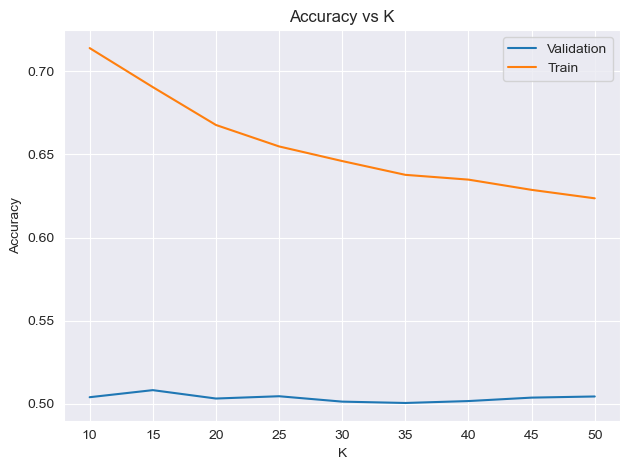

In [7]:
k_values = [item[0] for item in best_k]
validation_accuracy_values = [item[1] for item in best_k]
train_accuracy_values = [item[2] for item in best_k]

plt.plot(k_values, validation_accuracy_values, label='Validation')
plt.plot(k_values, train_accuracy_values, label='Train')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K')
plt.legend()


plt.tight_layout()
plt.show()

There are some important considerations to take into account:

1. **Small \(k\):** A small \(k\) value implies that the prediction for a data point is heavily influenced by its immediate neighbors. This makes the model sensitive to local variations in the training data, which might not generalize well to unseen data.

2. **Total Accuracy:** The total accuracy across all targets is reported around 50%, which is the average of the accuracies for the three target variables. This value suggests that the model is performing slightly better than random chance.

3. **Generalization Concerns:** While the model might perform quite well on the training sets, the real test lies in its ability to generalize to unseen data. The model's performance on the test sets should be carefully examined to assess its effectiveness in predicting stock values for different time horizons.

# Logistic Regression

In this section, we explore the training process of Logistic Regression for the stock prediction problem, aiming to analyze its outcomes. Logistic Regression is a well-established algorithm for binary classification tasks, making it suitable for predicting whether users should buy or avoid stocks.

In [8]:
# Define datasets
datasets = [(X_train_1_scaled, Y_train_1, X_valid_1_scaled, Y_valid_1, X_test_1_scaled, Y_test_1),
            (X_train_2_scaled, Y_train_2, X_valid_2_scaled, Y_valid_2, X_test_2_scaled, Y_test_2),
            (X_train_3_scaled, Y_train_3, X_valid_3_scaled, Y_valid_3, X_test_3_scaled, Y_test_3)]

sum = 0

# Loop through datasets
for i, (X_train, Y_train, X_valid, Y_valid, X_test, Y_test) in enumerate(datasets):

    # Train
    lr = LogisticRegression(max_iter=1500)
    lr.fit(X_train, Y_train)
    train_acc = accuracy_score(y_true=Y_train, y_pred=lr.predict(X_train))
    valid_acc = accuracy_score(y_true=Y_valid, y_pred=lr.predict(X_valid))

    # Test
    lr_test = LogisticRegression(max_iter=1500)
    lr_test.fit(X_train, Y_train)
    test_acc = accuracy_score(y_true=Y_test, y_pred=lr_test.predict(X_test))
    print(f'Target {i + 1} - Train Accuracy: {train_acc:.2f} - Validation Accuracy: {valid_acc:.2f} - Test Accuracy: {test_acc:.2f}')
    sum += test_acc
    
# Total acc
print(f'Total acc: {sum / 3:.2f}')

Target 1 - Train Accuracy: 0.52 - Validation Accuracy: 0.49 - Test Accuracy: 0.52
Target 2 - Train Accuracy: 0.57 - Validation Accuracy: 0.49 - Test Accuracy: 0.52
Target 3 - Train Accuracy: 0.65 - Validation Accuracy: 0.52 - Test Accuracy: 0.50
Total acc: 0.51


The accuracy levels are relatively close for the different target periods, indicating a consistent but not particularly strong predictive performance across various prediction horizons. The model's accuracy on the training and validation sets is also similar, suggesting that the model is not overfitting too much to the training data. However, the accuracy levels are relatively low, indicating that the model may not be capturing the underlying patterns in the data effectively.
We should try to see if the dataset is balanced or not. If it is not balanced, we should try to balance it.

In [9]:
# show the number of 0 and 1 for target 1,5 and 30 days
print('Target 1 day')
print(df['Target_1day'].value_counts())
print('Target 5 days')
print(df['Target_5days'].value_counts())
print('Target 30 days')
print(df['Target_30days'].value_counts())

Target 1 day
Target_1day
0.0    12886
1.0    12834
Name: count, dtype: int64
Target 5 days
Target_5days
1.0    13228
0.0    12492
Name: count, dtype: int64
Target 30 days
Target_30days
1.0    13353
0.0    12367
Name: count, dtype: int64


The classes aren't unbalanced, so we don't need to balance them.

# Artificial Neural Networks

In this phase of our analysis, we turn our attention to the Artificial Neural Networks (ANN) algorithm. This algorithm is a powerful tool for capturing complex, non-linear patterns in data, making it suitable for our stock prediction problem. The objective is to assess the performance of the ANN algorithm by experimenting with different configurations for the number of nodes, number of layers, and maximum number of iterations. By varying these parameters, we can observe how they impact the model's predictive accuracy.

In [10]:
# Initialize lists to store histories
histories = []

for target, X_train_80, X_train, X_valid, X_test, Y_train_80, Y_train, Y_valid, Y_test in [
    (1, X_train_1_80, X_train_1, X_valid_1, X_test_1, Y_train_1_80, Y_train_1, Y_valid_1, Y_test_1),
    (2, X_train_2_80, X_train_2, X_valid_2, X_test_2, Y_train_2_80, Y_train_2, Y_valid_2, Y_test_2),
    (3, X_train_3_80, X_train_3, X_valid_3, X_test_3, Y_train_3_80, Y_train_3, Y_valid_3, Y_test_3)
]:
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize parameters
    best_acc = 0
    best_epoch = 0
    best_node = 0
    best_layer = 0 

    # Initialize history dictionary
    history_dict = {'accuracy': [], 'validation_accuracy': [], 'test_accuracy': [], 'loss': [], 'validation_loss': [], 'test_loss': []}
    
    # Tuning parameters
    for nodes in [8, 16, 24]:
        for n_layers in [1, 2, 3]:
            for epochs in [30, 50, 100]:
                

                model = models.Sequential()
                model.add(layers.Dense(nodes, activation='relu', input_shape=(X_train_scaled.shape[1],)))
                for _ in range(n_layers):
                    model.add(layers.Dense(nodes, activation='relu'))
                model.add(layers.Dense(1, activation='relu'))
                model.compile(optimizer=optimizers.legacy.Adam(learning_rate=0.01),
                              loss='binary_crossentropy',
                              metrics=['accuracy'])
                
                early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

                history = model.fit(X_train_scaled, Y_train, epochs=epochs, validation_data=(X_valid_scaled, Y_valid), callbacks=[early_stopping], verbose=0)

                # Store history information
                history_dict['accuracy'].extend(history.history['accuracy'])
                history_dict['validation_accuracy'].extend(history.history.get('val_accuracy', []))  # Use get to handle missing key
                test_eval = model.evaluate(X_test_scaled, Y_test, verbose=0)
                history_dict['test_accuracy'].append(test_eval[1])  # Evaluate on test set
                history_dict['loss'].extend(history.history['loss'])
                history_dict['validation_loss'].extend(history.history.get('val_loss', []))  # Use get to handle missing key
                history_dict['test_loss'].append(test_eval[0])  # Evaluate on test set

                if test_eval[1] > best_acc:
                    best_acc = test_eval[1]
                    best_epoch = epochs
                    best_node = nodes
                    best_layer = n_layers

    histories.append((target, history_dict, best_epoch, best_node, best_layer, best_acc))

    print(f'Target {target} - Best Epochs: {best_epoch}, Best Nodes: {best_node}, Best Layers: {best_layer}, Best Accuracy: {best_acc:.2f}')

Target 1 - Best Epochs: 30, Best Nodes: 8, Best Layers: 2, Best Accuracy: 0.52
Target 2 - Best Epochs: 50, Best Nodes: 8, Best Layers: 1, Best Accuracy: 0.52
Target 3 - Best Epochs: 50, Best Nodes: 8, Best Layers: 1, Best Accuracy: 0.52


In [11]:
datas = []

for target, X_train_80, X_train, X_valid, X_test, Y_train_80, Y_train, Y_valid, Y_test in [
    (1, X_train_1_80, X_train_1, X_valid_1, X_test_1, Y_train_1_80, Y_train_1, Y_valid_1, Y_test_1),
    (2, X_train_2_80, X_train_2, X_valid_2, X_test_2, Y_train_2_80, Y_train_2, Y_valid_2, Y_test_2),
    (3, X_train_3_80, X_train_3, X_valid_3, X_test_3, Y_train_3_80, Y_train_3, Y_valid_3, Y_test_3)
]:
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)
    
    nodes = histories[target-1][3]
    n_layers = histories[target-1][4]
    epochs = histories[target-1][2]
    
    # Tuning parameters
    model = models.Sequential()
    model.add(layers.Dense(nodes, activation='sigmoid', input_shape=(X_train_scaled.shape[1],)))
    for _ in range(n_layers):
        model.add(layers.Dense(nodes, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=epochs, restore_best_weights=True)

    history = model.fit(X_train_scaled, Y_train, epochs=epochs, validation_data=(X_valid_scaled, Y_valid), callbacks=[early_stopping], verbose=0)

    # Store history information
    train_acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', [])  # Use get to handle missing key
    test_eval = model.evaluate(X_test_scaled, Y_test, verbose=0)
    test_acc = test_eval[1] # Evaluate on test set
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])  # Use get to handle missing key
    test_loss = test_eval[0]  # Evaluate on test set
    
    datas.append((target, train_acc, val_acc, test_acc, train_loss, val_loss, test_loss))

    print(f'Target {target} - Train Accuracy: {np.mean(train_acc):.2f} - Validation Accuracy: {np.mean(val_acc):.2f} - Test Accuracy: {np.mean(test_acc):.2f}')

Target 1 - Train Accuracy: 0.53 - Validation Accuracy: 0.50 - Test Accuracy: 0.51
Target 2 - Train Accuracy: 0.61 - Validation Accuracy: 0.50 - Test Accuracy: 0.51
Target 3 - Train Accuracy: 0.74 - Validation Accuracy: 0.52 - Test Accuracy: 0.47


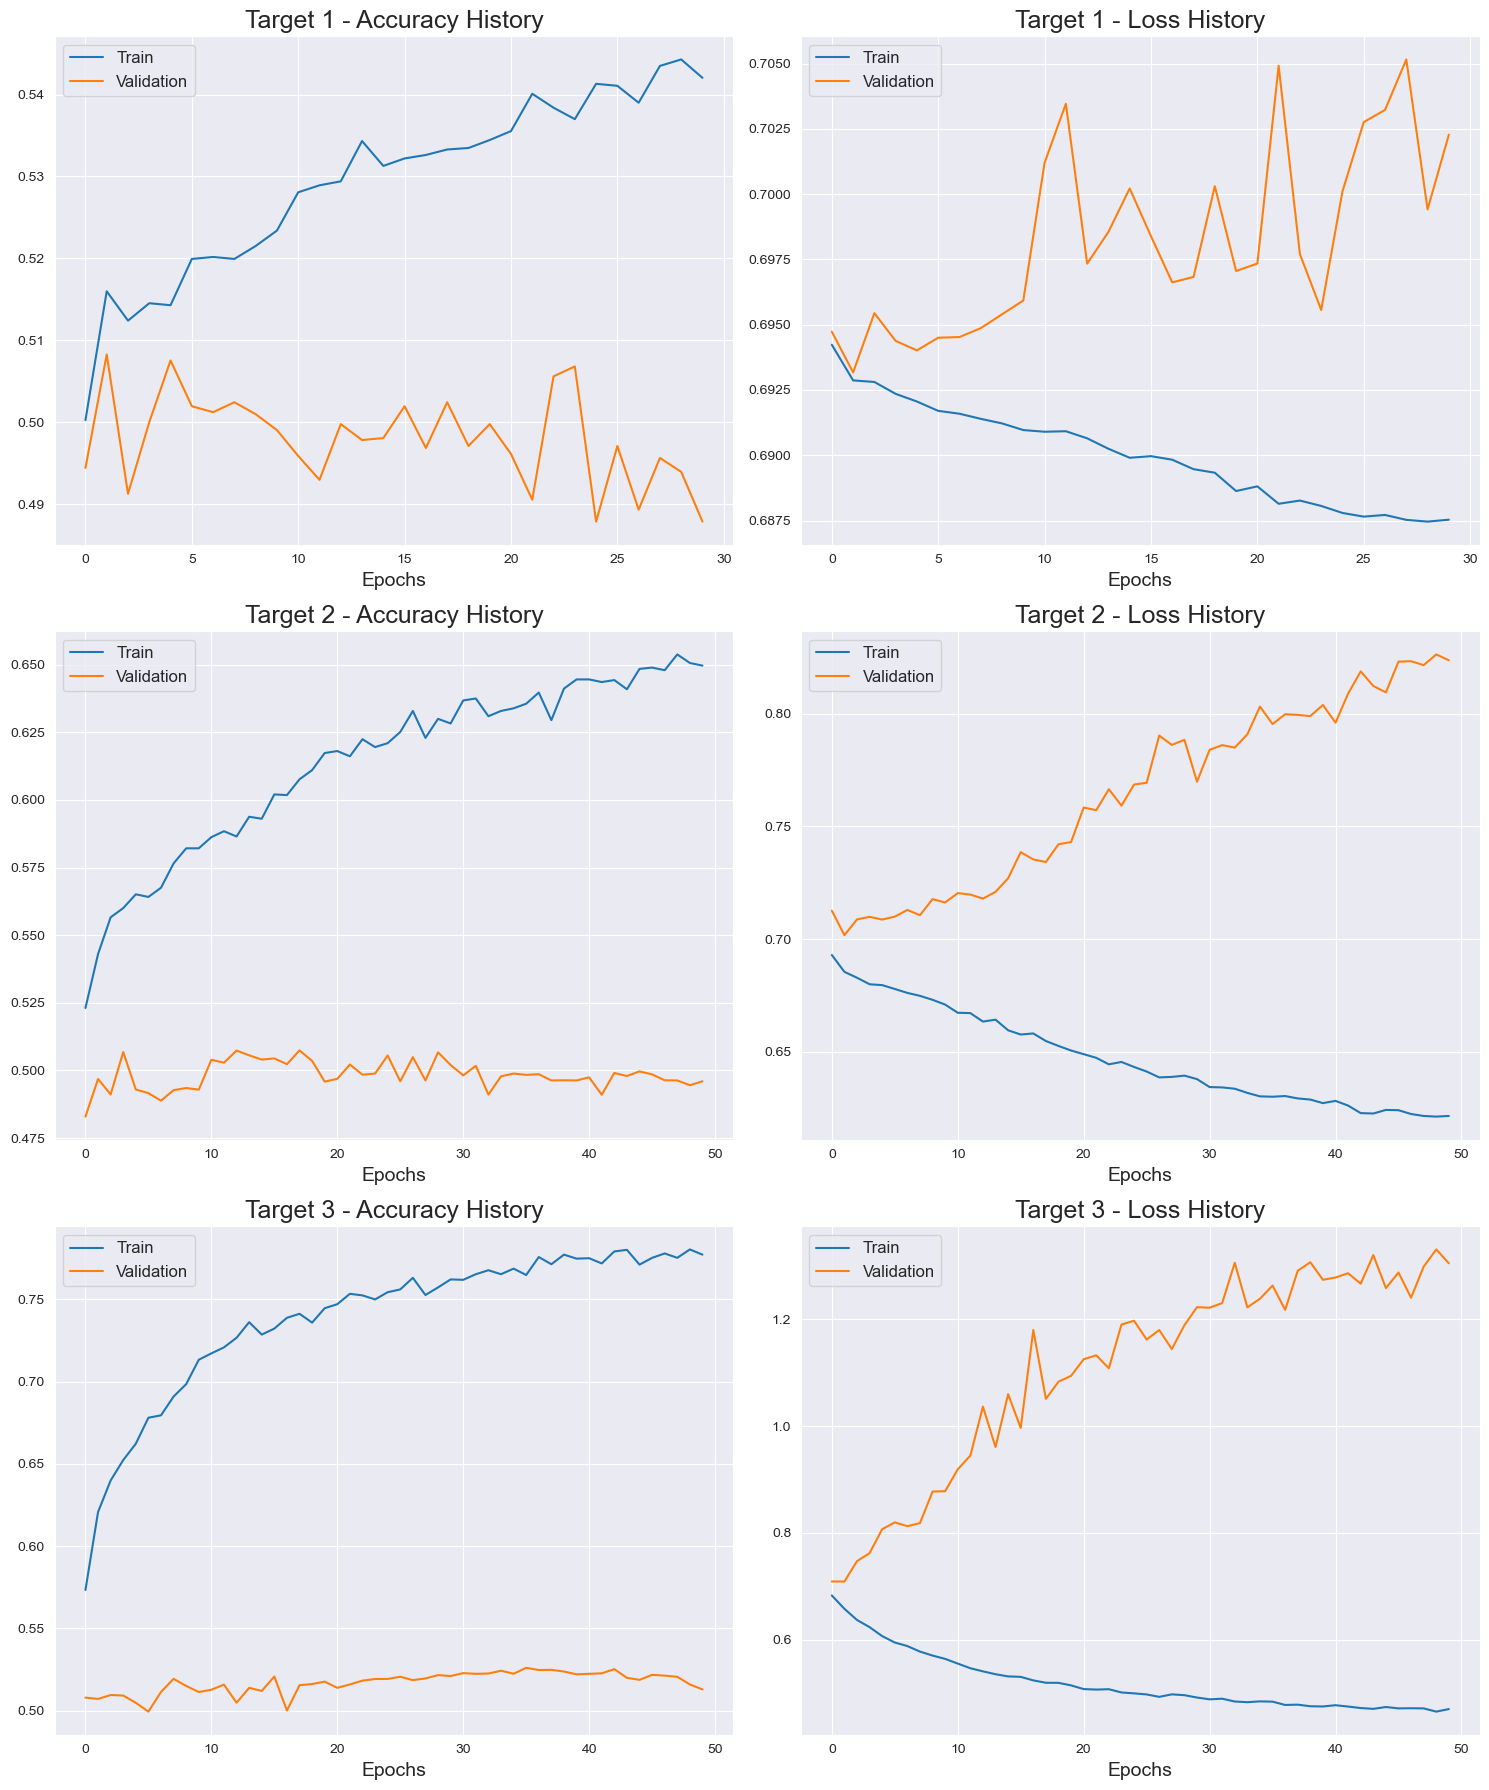

In [12]:
# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))

for i, (target, train_acc, val_acc, test_acc, train_loss, val_loss, test_loss) in enumerate(datas):
    row = i
    col_acc = 0
    col_loss = 1
    
    axes[row, col_acc].plot(train_acc, label='Train')
    axes[row, col_acc].plot(val_acc, label='Validation')
    axes[row, col_acc].set_title(f"Target {target} - Accuracy History", fontsize=18)
    axes[row, col_acc].set_xlabel("Epochs", fontsize=14)
    axes[row, col_acc].legend(fontsize=12)
    
    axes[row, col_loss].plot(train_loss, label='Train')
    axes[row, col_loss].plot(val_loss, label='Validation')
    axes[row, col_loss].set_title(f"Target {target} - Loss History", fontsize=18)
    axes[row, col_loss].set_xlabel("Epochs", fontsize=14)
    axes[row, col_loss].legend(fontsize=12)

plt.tight_layout()
plt.show()

The results indicate that the ANN algorithm is not performing well on the given dataset, with accuracy levels around 50% for all target variables. This outcome suggests that the model is not capturing the underlying patterns in the data effectively, resulting in poor predictive performance. The accuracy levels are also similar across the training, validation, and test sets, indicating that the model is not overfitting much to the training data.

# Random Forest

In this section of the document, we explore the Random Forest algorithm, which is a powerful tool for capturing complex patterns in data. The objective is to assess the performance of the Random Forest algorithm by experimenting with different configurations for the number of estimators and the minimum samples leaf. By varying these parameters, we can observe how they impact the model's predictive accuracy.

In [13]:
best_params = []
sum = 0
for n_estimators in [10, 25, 50]:
    print(f'N Estimators: {n_estimators}')
    for min_samples_leaf in [2,5,10]:
        print(f'Min Samples Leaf: {min_samples_leaf}')
        # Target 1 day
        rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
        rf.fit(X_train_1, Y_train_1)
        train_acc = accuracy_score(y_true=Y_train_1, y_pred=rf.predict(X_train_1))
        scores = cross_val_score(rf, X_train_1_80, Y_train_1_80, cv=5, scoring='accuracy', verbose=0)
        print(f"Train set 1: {train_acc:.2f}")
        print(f'Validation set 1: {scores.mean():.2f}')
        sum = scores.mean()
        # Target 5 days
        rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
        rf.fit(X_train_2, Y_train_2)
        train_acc = accuracy_score(y_true=Y_train_2, y_pred=rf.predict(X_train_2))
        scores = cross_val_score(rf, X_train_2_80, Y_train_2_80, cv=5, scoring='accuracy', verbose=0)
        print(f"Train set 2: {train_acc:.2f}")
        print(f'Validation set 2: {scores.mean():.2f}')
        sum += scores.mean()
        # Target 30 days
        rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
        rf.fit(X_train_3, Y_train_3)
        train_acc = accuracy_score(y_true=Y_train_3, y_pred=rf.predict(X_train_3))
        scores = cross_val_score(rf, X_train_3_80, Y_train_3_80, cv=5, scoring='accuracy', verbose=0)
        print(f"Train set 3: {train_acc:.2f}")
        print(f'Validation set 3: {scores.mean():.2f}\n')
        sum += scores.mean()
        best_params.append({
            'n_estimators': n_estimators,
            'min_samples_leaf': min_samples_leaf,
            'average_accuracy': sum / 3
        })
        sum = 0

# Find the best parameters
best_param_set = max(best_params, key=lambda x: x['average_accuracy'])
print(f'Best Parameters: {best_param_set}')

N Estimators: 10
Min Samples Leaf: 2
Train set 1: 0.97
Validation set 1: 0.50
Train set 2: 0.98
Validation set 2: 0.47
Train set 3: 0.99
Validation set 3: 0.52

Min Samples Leaf: 5
Train set 1: 0.91
Validation set 1: 0.49
Train set 2: 0.94
Validation set 2: 0.48
Train set 3: 0.97
Validation set 3: 0.52

Min Samples Leaf: 10
Train set 1: 0.84
Validation set 1: 0.50
Train set 2: 0.88
Validation set 2: 0.49
Train set 3: 0.95
Validation set 3: 0.53

N Estimators: 25
Min Samples Leaf: 2
Train set 1: 0.99
Validation set 1: 0.49
Train set 2: 0.99
Validation set 2: 0.48
Train set 3: 1.00
Validation set 3: 0.51

Min Samples Leaf: 5
Train set 1: 0.96
Validation set 1: 0.49
Train set 2: 0.96
Validation set 2: 0.48
Train set 3: 0.99
Validation set 3: 0.52

Min Samples Leaf: 10
Train set 1: 0.89
Validation set 1: 0.49
Train set 2: 0.92
Validation set 2: 0.48
Train set 3: 0.95
Validation set 3: 0.52

N Estimators: 50
Min Samples Leaf: 2
Train set 1: 1.00
Validation set 1: 0.49
Train set 2: 1.00
Vali

In [14]:
j = best_param_set['n_estimators']
k = best_param_set['min_samples_leaf']
print('Best n estimators: ' + str(j))
print('Best min samples leaf: ' + str(k))
# Target 1 day
rm_1 = RandomForestClassifier(n_estimators=j, min_samples_leaf=k)
rm_1.fit(X_train_1_80, Y_train_1_80)
test_acc_1 = accuracy_score(y_true= Y_test_1, y_pred= rm_1.predict(X_test_1))
print('Test set 1: {:.2f}'.format(test_acc_1))

# Target 5 days
rm_2 = RandomForestClassifier(n_estimators=j, min_samples_leaf=k)
rm_2.fit(X_train_2_80, Y_train_2_80)
test_acc_2 = accuracy_score(y_true= Y_test_2, y_pred= rm_2.predict(X_test_2))
print('Test set 2: {:.2f}'.format(test_acc_2))

# Target 30 days
rm_3 = RandomForestClassifier(n_estimators=j, min_samples_leaf=k)
rm_3.fit(X_train_3_80, Y_train_3_80)
test_acc_3 = accuracy_score(y_true= Y_test_3, y_pred= rm_3.predict(X_test_3))
print('Test set 3: {:.2f}'.format(test_acc_3))

# Total acc
print('Total acc: {:.2f}'.format((test_acc_1 + test_acc_2 + test_acc_3) / 3))

Best n estimators: 10
Best min samples leaf: 10
Test set 1: 0.50
Test set 2: 0.51
Test set 3: 0.51
Total acc: 0.51


We have identified the optimal `max_depth`,`n_estimators` and `min_samples_leaf`  parameter for the Random Forest algorithm as `i,j,k`, we now aim to delve deeper into the feature importance of our dataset. This analysis seeks to uncover which features significantly contribute to the predictive performance of the model.

The Random Forest algorithm provides a feature importance score for each input feature, indicating its contribution to the overall predictive accuracy. By understanding the importance of each feature, we can identify key variables that play a crucial role in predicting stock values over different time horizons (1 day, 5 days, and 30 days).

This investigation into feature importance will enhance our understanding of the underlying factors driving the model's predictions and help us identify any redundant or less relevant features that may be excluded from future iterations of the model.

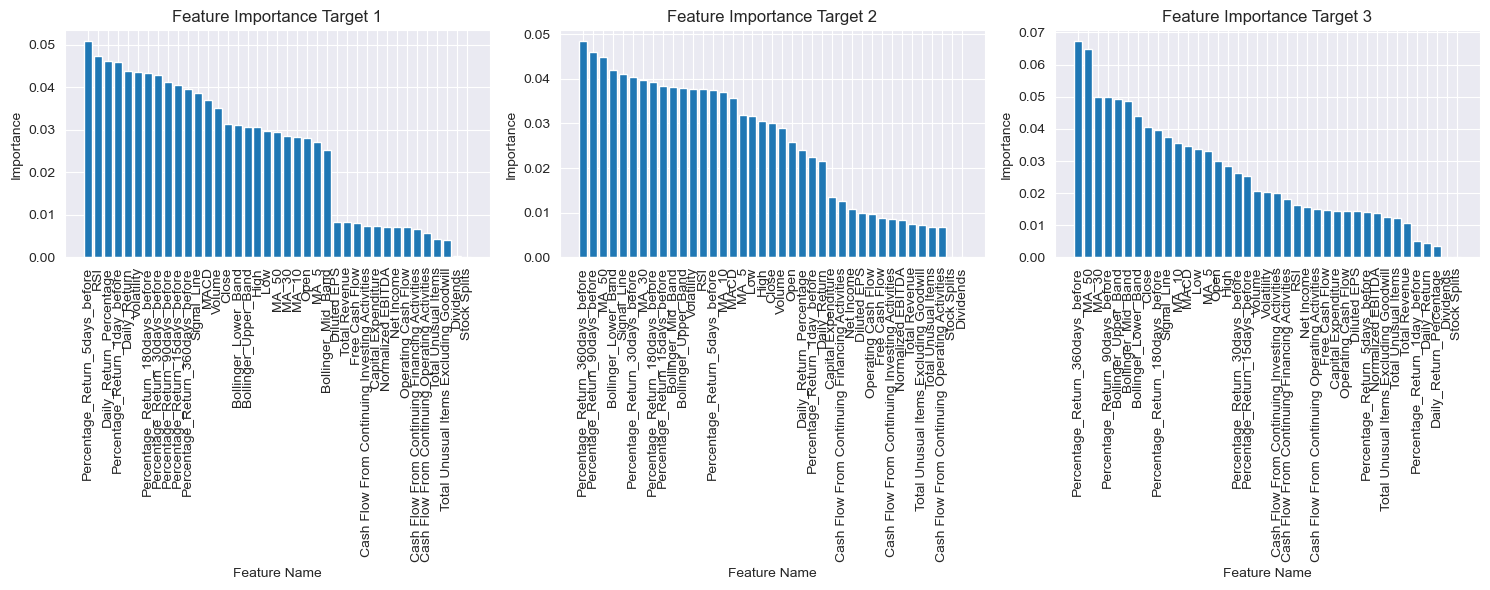

In [15]:
# Define the RandomForestClassifiers for each target
rf_models = [rm_1, rm_2, rm_3]
X_train_sets = [X_train_1_80, X_train_2_80, X_train_3_80]
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Iterate through targets
for target, rf_model, X_train_set, ax in zip(range(1, 4), rf_models, X_train_sets, axes):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Calculate the cumulative importance
    cumulative_importance = np.cumsum(importances)

    # Plotting
    ax.bar(range(X_train_set.shape[1]), importances[indices], align="center")
    ax.set_xticks(range(X_train_set.shape[1]))
    ax.set_xticklabels(X_train_set.columns[indices], rotation=90)
    ax.set_title(f"Feature Importance Target {target}")
    ax.set_xlabel("Feature Name")
    ax.set_ylabel("Importance")

plt.tight_layout()
plt.show()

After scrutinizing the dataset, we decide to exculde from the dataset all the less important features that comes after the 90% of cumulative importance. This is done to reduce the noise in the dataset and to improve the performance of the model.

We then train the model again with the new dataset and we compare the results with the previous ones.

Test set 1 with new features: 0.51


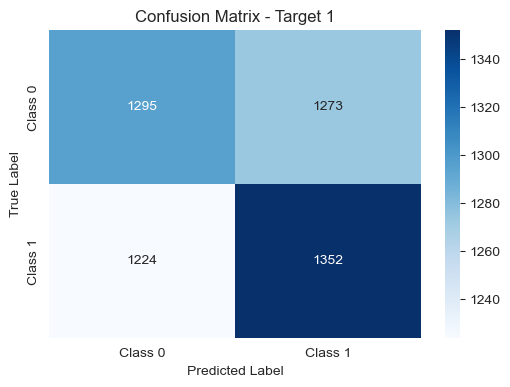

Test set 2 with new features: 0.51


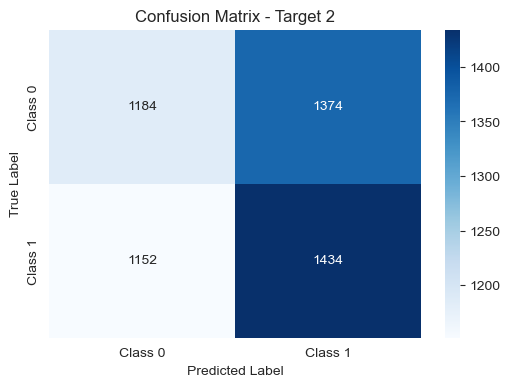

Test set 3 with new features: 0.51


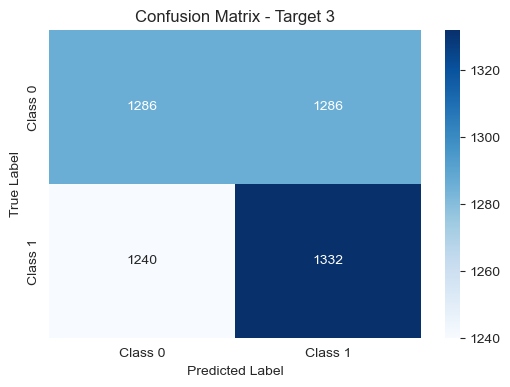

Total acc with new features: 0.51


In [16]:
# Function to select features based on cumulative importance
def select_features(importances, threshold=0.9):
    sorted_indices = importances.argsort()[::-1]
    cumulative_importance = 0
    selected_features = []

    for index in sorted_indices:
        cumulative_importance += importances[index]
        selected_features.append(index)
        if cumulative_importance >= threshold:
            break

    return selected_features

# Function to print confusion matrix
def plot_confusion_matrix(model, X_test, Y_test, target_number):
    # Predictions
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(Y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - Target {target_number}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

feature_importances_1 = rm_1.feature_importances_
feature_importances_2 = rm_2.feature_importances_
feature_importances_3 = rm_3.feature_importances_

# Select features for each model
selected_features_1 = select_features(feature_importances_1)
selected_features_2 = select_features(feature_importances_2)
selected_features_3 = select_features(feature_importances_3)

# Create new datasets with selected features
new_x_1 = X.iloc[:, selected_features_1]
new_x_2 = X.iloc[:, selected_features_2]
new_x_3 = X.iloc[:, selected_features_3]

new_x_datasets = [(new_x_1, Y_1), (new_x_2, Y_2), (new_x_3, Y_3)]

# Test with the new datasets
test_accuracies = []
for i, (new_x, Y) in enumerate(new_x_datasets):
    # Split the data
    X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(new_x, Y, test_size=0.2, shuffle=False)

    # Create a new RandomForestClassifier with the best parameters
    rf_new = RandomForestClassifier( n_estimators=j, min_samples_leaf=k)
    rf_new.fit(X_train_new, Y_train_new)

    # Test set accuracy
    test_acc_new = accuracy_score(y_true=Y_test_new, y_pred=rf_new.predict(X_test_new))
    print(f'Test set {i + 1} with new features: {test_acc_new:.2f}\n')

    test_accuracies.append(test_acc_new)
    plot_confusion_matrix(rf_new, X_test_new, Y_test_new, i + 1)

# Total acc with new features
total_acc_new = np.mean(test_accuracies)
print(f'Total acc with new features: {total_acc_new:.2f}')

Despite removing the less informative features from our dataset, the overall results remained relatively stable. The accuracy scores on the test sets for each target (1 day, 5 days, and 30 days) and the total accuracy did not exhibit significant changes.

This outcome suggests that the excluded features might not have played a substantial role in influencing the predictive performance of our models. While our analysis indicates that removing these features did not lead to a noticeable improvement, it underscores the importance of thorough feature engineering and continuous refinement to achieve optimal model performance.



# Conclusions

After extensively testing various supervised learning models, our findings reveal that none of the models performed as expected. Surprisingly, all the results yielded accuracy levels only marginally better than random chance, and there was no significant performance distinction among the tested models. Notably, logistic regression exhibited less overfitting compared to the other models, providing a glimpse of stability in its predictions. In light of these outcomes, our attention turns to exploring reinforcement learning, a crucial next step in our study. The objective is to assess whether reinforcement learning can outperform supervised learning methodologies in the context of our specific task. This shift in focus marks a pivotal moment in our research, offering the opportunity to uncover insights that traditional supervised learning models may not have captured effectively.